In [1]:
%matplotlib inline
# %matplotlib qt
import json
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.experiment_container import load_by_id
from qcodes.dataset.plotting import plot_by_id

import nanotune as nt
from nanotune.model.capacitancemodel import CapacitanceModel

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /Users/jana/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : /Users/jana/.qcodes/logs/210415-42156-qcodes.log


## Capacitance model for quantum dots


The system of electrostatic gates, dots and reservoirs is represented by a system of conductors connected via resistors and capacitors. Albeit classical and simple, the capacitance model explains and qualitatively reproduces relevant transport features of gate-defined quantum dots.

The capacitance model is defined by a capacitance matrix $\mathbf{C}$, whose elements $C_{ij}$ are the capacitances between individual elements $i$ and $j$. We distinguish between two different types of elements, the charge and the voltage nodes, representing quantum dots and electrostatic gates respectively. Each node $i$ is defined by its charge $Q_{i}$ and electrical potential $V_{i}$. For simplicity, we write charges and potentials on all nodes of the system in vector notation. We denote charges on charge and voltages nodes by $\vec{Q_{c}}$ and $\vec{Q_{v}}$ respectively, and electrical potentials by $\vec{V}_{c}$ and $\vec{V}_{v}$. The capacitance model allows to calculate potentials on voltage nodes resulting in the desired number of charges on charge nodes. We consider a system of $N_{c}$ charge nodes and $N_{v}$ voltage nodes.

The capacitor connecting node $j$ and node $k$ has a capacitance $C_{jk}$ and stores a charge $q_{jk}$. The total charge on node $j$ is the sum of the charges of  all capacitors connected to it, 
\begin{equation}
Q_{j} = \sum_{k} q_{jk} = \sum_{k} C_{jk} (V_{j} - V_{k}).
\end{equation}
Using the vector notation for charges and electrical potentials introduced above, this relation can be expressed using the capacitance matrix, $\vec{Q} = \mathbf{C} \vec{V}$. Distinguishing between charge and voltage node sub-systems, this relation becomes
\begin{equation}
\begin{pmatrix} \vec{Q_{c}} \\ \vec{Q_{v}} \end{pmatrix} = 
\begin{pmatrix}
\mathbf{C_{cc}} & \mathbf{C_{cv}} \\
\mathbf{C_{vc}} & \mathbf{C_{vv}}
\end{pmatrix}
\begin{pmatrix}
\vec{V_{c}} \\
\vec{V}_{v}
\end{pmatrix}.
\end{equation}
Diagonal elements of the capacitance matrix, $C_{jj}$, are total capacitances of each node and carry the opposite sign of the matrix's off-diagonal elements.
The off-diagonal elements of $\mathbf{\mathbf{C_{cc}}}$ are capacitances between charge nodes, while the off-diagonal elements of $\mathbf{\mathbf{C_{vv}}}$ are capacitances between voltage nodes. The elements of $\mathbf{\mathbf{C_{cv}}}$ are capacitances between voltage and charge nodes, and allow to calculate so-called virtual gate coefficients - useful knobs in semiconductor qubit experiments.


Illustration of capacitances between gates and gates and dots:  
Each gate voltage $V_{i}$ will tune the number of charges on each dot.  The capacitance of the dots, $C_{A}$ and $C_{B}$, are sums of all capacitances connects to $A$ and $B$ respectively.  Gates located further away will have a smaller capacitive coupling. Most labels of capacitance between gates are omitted for readability. 
<img src="quantum_dots-08.png" width="300"/>
Names and layout indices of gates:
Six electrostatic gates, three barriers and two plungers, are used to define two, possibly coupled, quantum dots. Barrier gates are primarily used to create potential barriers, while plungers are used to tune electron density and thus the dot's electrochemical potentials.
<img src="quantum_dots-09.png" width="200"/>


Initiate or set database where data should be saved. When initializing a database a new qcodes experiment needs to be created as well.

In [2]:
exp_name = 'capacitance_extraction'
sample_name = 'capa_model'
db_name = 'capa_model_test.db'
nt.new_database(db_name, '.')
new_experiment(exp_name, sample_name)
# nt.set_database(db_name)

capacitance_extraction#capa_model#2@/Users/jana/Documents/code/nanotune/nanotune/docs/capacitance_model/capa_model_test.db
--------------------------------------------------------------------------------------------------------------------------

Initialize an instance of CapacitanceModel with six gates and two dots

In [3]:
voltage_nodes = {
    0: 'top_barrier',
    1: 'left_barrier',
    2: 'left_plunger',
    3: 'central_barrier',
    4: 'right_plunger',
    5: 'right_barrier',
}
charge_nodes = {
    0: 'A',
    1: 'B'
}

qdot = CapacitanceModel(
    'qdot',
    charge_nodes=charge_nodes,
    voltage_nodes=voltage_nodes,
    db_name=db_name,
    db_folder='.'
)


Set voltages, define capacitance matrix and calculate ground state dot occupation

In [4]:
qdot.V_v([
    -1,  # top_barrier
    -0.1,  # left_barrier
    -4.2,  # left_plunger
    -1,  # central_barrier
    -0.5,  # right_plunger
    -0.3,  # right_barrier
])
# inter-dot capacitance
qdot.C_cc([[-8e-18]])
# capacitances between gates and dots
#           top_b    left_b left_p center right_p  right_b    
qdot.C_cv([[0.5e-18, 1e-18, 5e-18, 1e-18, 0.1e-18, 0.1e-18],   #  A
           [0.5e-18, 0.1e-18, 1e-18, 2e-18, 9e-18, 2e-18]])    #  B

print(qdot.determine_N())

[14.0, 7.0]


Define which dot occupancies to probe and calculate respective voltage ranges of two gates to sweep.

In [5]:
N_limits = [(0, 3), (0, 3)]
sweep_ranges = qdot.determine_sweep_voltages([2, 4], N_limits=N_limits)
print(sweep_ranges)

[[0.31981233977907475, -0.6329423026592067], [0.31003555776603053, -0.1181622049334346]]


Starting experimental run with id: 4. 
CPU times: user 2min 34s, sys: 14.1 s, total: 2min 48s
Wall time: 2min 3s


([<AxesSubplot:title={'center':'Run #4, Experiment capacitance_extraction (capa_model)'}, xlabel='voltage node left_plunger (V[2]) (mV)', ylabel='voltage node right_plunger (V[4]) (mV)'>],
 [<matplotlib.colorbar.Colorbar at 0x7fcd1284c7d0>])

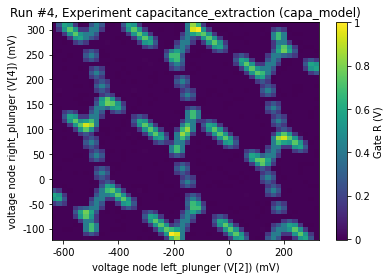

In [6]:
%%time
dataid = qdot.sweep_voltages(
    [2, 4],
     sweep_ranges,
     n_steps=[50,50],
     target_snr_db=10,
     e_temp=2e-21,
     kernel_widths=[1, 1],  # for broadening with gaussian_filter
     broaden=True,
     add_noise=True,
     add_charge_jumps=False,
)
plot_by_id(dataid)

Sweep one voltage to show Coulomb oscillations

Starting experimental run with id: 1. 
CPU times: user 5.93 s, sys: 551 ms, total: 6.48 s
Wall time: 4.49 s


([<AxesSubplot:title={'center':'Run #1, Experiment capacitance_extraction (capa_model)'}, xlabel='voltage node left_plunger (V[2]) (mV)', ylabel='Gate R (V)'>],
 [None])

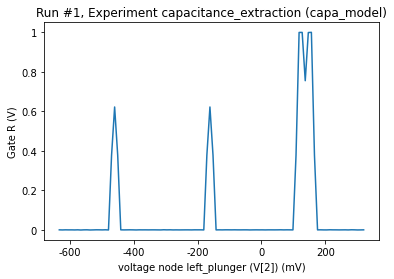

In [6]:
%%time
dataid = qdot.sweep_voltage(2, sweep_ranges[0],
                            n_steps=100,
                            target_snr_db=20,
                            e_temp=3e-21,
                           )
plot_by_id(dataid)